In [1]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
csv_files = glob.glob(os.path.join('//global/scratch/users/norahluo/trajectory', '*.csv'))
demo = pd.read_csv('//global/scratch/users/norahluo/demo.csv')

In [4]:
isinstance(1, np.ndarray)

False

In [3]:
np.log(1/0.13 - 1)

1.900958761193047

In [2]:
np.log(2.8)

1.0296194171811581

#### Demographic

In [8]:
demo.columns

Index(['Unnamed: 0', 'panelist_id', 'home_state', 'home_state_county',
       'city_name', 'postal_code', 'dfrw_cap_mean', 'gender', 'age',
       'edu_level', 'ethnicity', 'is_hispanic', 'occupational_status',
       'hh_income', 'hh_income_mid', 'hh_size'],
      dtype='object')

In [5]:
demo['gender'].value_counts()/573

FEMALE    0.511344
MALE      0.488656
Name: gender, dtype: float64

In [9]:
demo['edu_level'].value_counts()/573

High School               0.462478
University/College        0.441536
Postgraduate Education    0.080279
None completed            0.010471
Compulsory school         0.005236
Name: edu_level, dtype: float64

In [11]:
demo['hh_income'].value_counts()/573

$25,000 - $49,999 USD      0.356021
$50,000 - $79,999 USD      0.235602
$80,000 - $99,999 USD      0.122164
$15,000 - $24,999 USD      0.120419
$100,000 - $149,999 USD    0.101222
$0 - $14,999 USD           0.041885
$150,000 - $199,999 USD    0.013962
$200,000 USD or more       0.008726
Name: hh_income, dtype: float64

In [24]:
def age_group(age):
    if age < 18:
        return 'Under 18'
    elif age < 25:
        return '18 to 24 years'
    elif age < 35:
        return '25 to 34 years'
    elif age < 45:
        return '35 to 44 years'
    elif age < 55:
        return '45 to 54 years'
    elif age < 65:
        return '55 to 64 years'
    else:
        return 'Over 65'
    

In [25]:
demo['age_group'] = demo['age'].apply(age_group)

In [28]:
demo.age_group.value_counts()/573

35 to 44 years    0.350785
25 to 34 years    0.307155
45 to 54 years    0.198953
55 to 64 years    0.094241
18 to 24 years    0.036649
Over 65           0.012216
Name: age_group, dtype: float64

#### Trajectories

In [12]:
mindate, maxdate = [], []
len_ = []
for i in csv_files:
    df = pd.read_csv(i, parse_dates = ['date'])
    mindate.append(df.date.min())
    maxdate.append(df.date.max())
    len_.append(len(df[df.date >= '2020-01-06']))

    
print(min(mindate), max(mindate), min(maxdate), max(maxdate), min(len_), max(len_), np.mean(len_), np.std(len_))

2019-12-26 00:00:00 2020-02-29 00:00:00 2022-01-03 00:00:00 2022-09-30 00:00:00 692 999 894.7294938917976 96.71114465299692


In [2]:
def per_commute_by_stageWday_ind(stage_cat, earliest):
    """
    Given the earlist record to be included in the trajectory,
    
    return a dataframe with the frequency of commuting on a given weekday across covid stages, average across individuals
    
    """
    
    df_ = pd.read_csv(csv_files[0], parse_dates = ['date'])
    df_ = df_.loc[df_.date > earliest]
    df_ = df_.groupby([stage_cat, 'weekday'])['commute_filled'].mean().unstack()
    count = 1 - df_.isnull().astype(int)
    
    for i in csv_files[1:]:
        df = pd.read_csv(i, parse_dates = ['date'])
        df = df.loc[df.date > earliest]

        df = df.groupby([stage_cat, 'weekday'])['commute_filled'].mean().unstack()
        if 'post-' + stage_cat.split('_')[0] not in df.index:
            df.loc['post-'+ stage_cat.split('_')[0]] = np.nan
        count += 1 - df.isnull().astype(int)
        df.fillna(0, inplace = True)
        df_ = df_ + df
        
    df_ = df_/count
    
    return df_

In [3]:
def per_commute_by_stageWday_sce(stage_cat, earliest):
    """
    Given the earlist record to be included in the trajectory,
    
    return a dataframe with the frequency of commuting on a given weekday across covid stages, average across choice scenarios
    
    """
    
    rec = pd.read_csv(csv_files[0], parse_dates = ['date'])
    rec = rec.loc[rec.date > earliest]
    df_ = rec.groupby([stage_cat, 'weekday'])['commute_filled'].sum().unstack()
    count_ = rec.groupby([stage_cat, 'weekday'])['commute_filled'].count().unstack()
    
    for i in csv_files[1:]:
        rec = pd.read_csv(i, parse_dates = ['date'])
        rec = rec.loc[rec.date > earliest]
        df = rec.groupby([stage_cat, 'weekday'])['commute_filled'].sum().unstack()
        count = rec.groupby([stage_cat, 'weekday'])['commute_filled'].count().unstack()
        
        if 'post-' + stage_cat.split('_')[0] not in df.index:
            df.loc['post-'+ stage_cat.split('_')[0]] = np.nan
            count.loc['post-'+ stage_cat.split('_')[0]] = np.nan          
        df.fillna(0, inplace = True)
        count.fillna(0, inplace = True)
        df_ += df
        count_ += count
        
    df_ = df_/count_
    
    return df_

In [4]:
df_1 = per_commute_by_stageWday_sce('vax_status', '2019-12-01')
df_2 = per_commute_by_stageWday_sce('vax_status', '2020-01-06')

<Axes: xlabel='vax_status'>

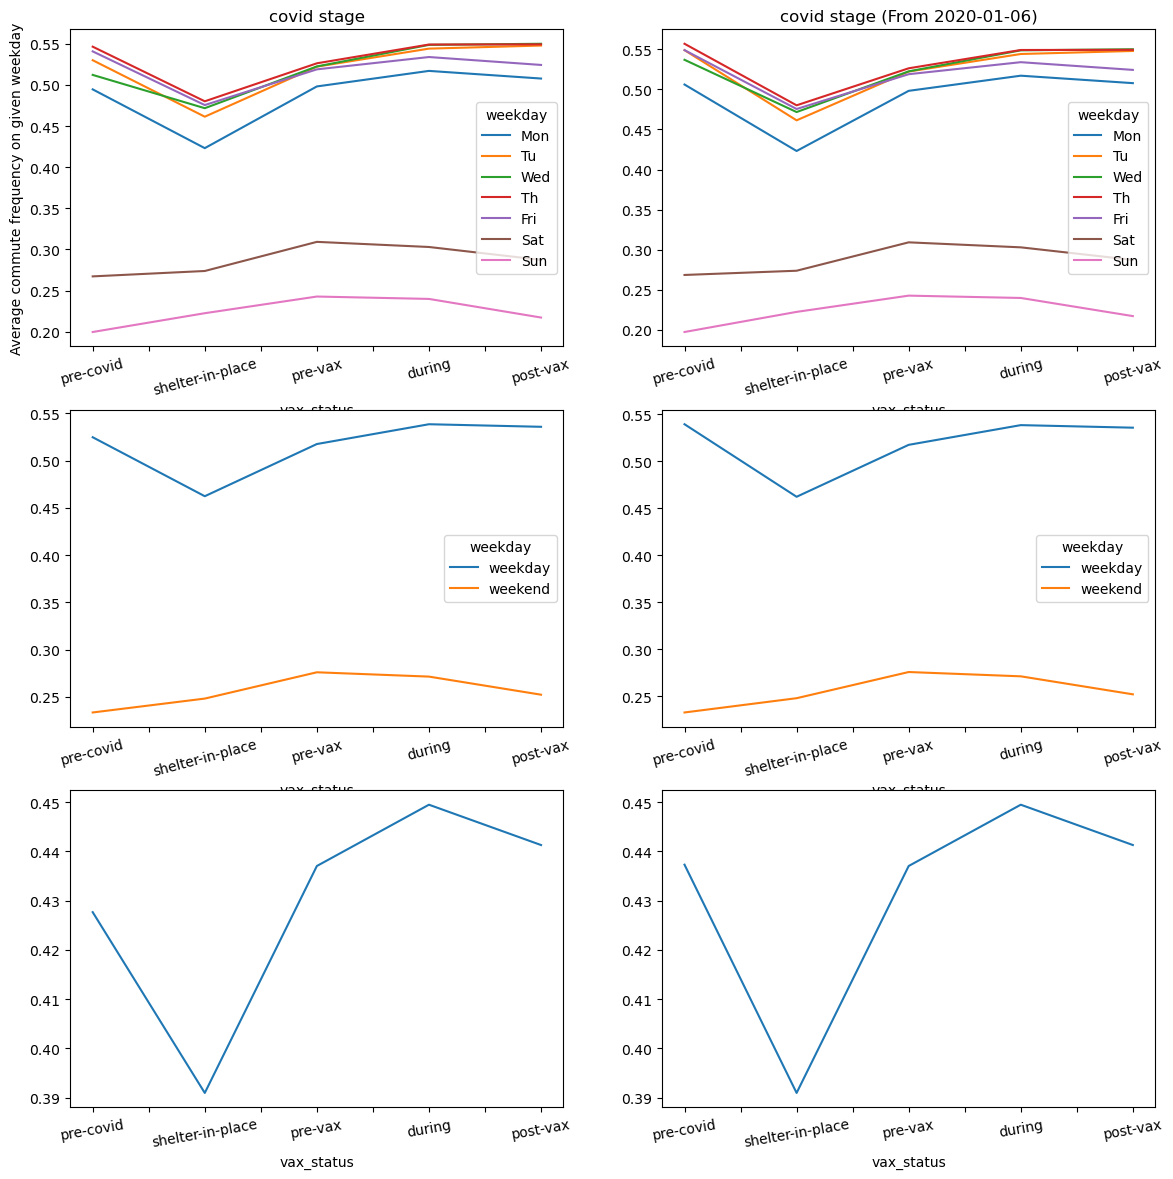

In [44]:
# seq = ['pre-pandemic', 'lockdown', 'pre-vaccine', 'early-vaccine', 'post-vaccine', 'omicron', 'post-covid']
seq = ['pre-covid', 'shelter-in-place', 'pre-vax', 'during', 'post-vax']

df_1.rename(columns = dict(zip([i for i in range(7)], ['Mon', 'Tu', 'Wed', 'Th', 'Fri', 'Sat', 'Sun'])), inplace = True)
df_2.rename(columns = dict(zip([i for i in range(7)], ['Mon', 'Tu', 'Wed', 'Th', 'Fri', 'Sat', 'Sun'])), inplace = True)
df_1['weekday'] = df_1.loc[:, 'Mon':'Fri'].mean(axis = 1)
df_1['weekend'] = df_1.loc[:, 'Sat':'Sun'].mean(axis = 1)
df_2['weekday'] = df_2.loc[:, 'Mon':'Fri'].mean(axis = 1)
df_2['weekend'] = df_2.loc[:, 'Sat':'Sun'].mean(axis = 1)

fig, axs = plt.subplots(3, 2, figsize = (14, 14)) 
df_1.loc[seq, :'Sun'].plot(rot = 15, ax = axs[0, 0], title = 'covid stage', ylabel = 'Average commute frequency on given weekday')
df_2.loc[seq, :'Sun'].plot(rot = 15, ax = axs[0, 1], title = 'covid stage (From 2020-01-06)')
df_1[['weekday', 'weekend']].loc[seq].plot(rot = 15, ax = axs[1, 0])
df_2[['weekday', 'weekend']].loc[seq].plot(rot = 15, ax = axs[1, 1])
df_1.T.describe().loc['mean'][seq].plot(rot = 10, ax = axs[2, 0] )
df_2.T.describe().loc['mean'][seq].plot(rot = 10, ax = axs[2, 1])

<Axes: xlabel='covid stage (From 2020-01-14)'>

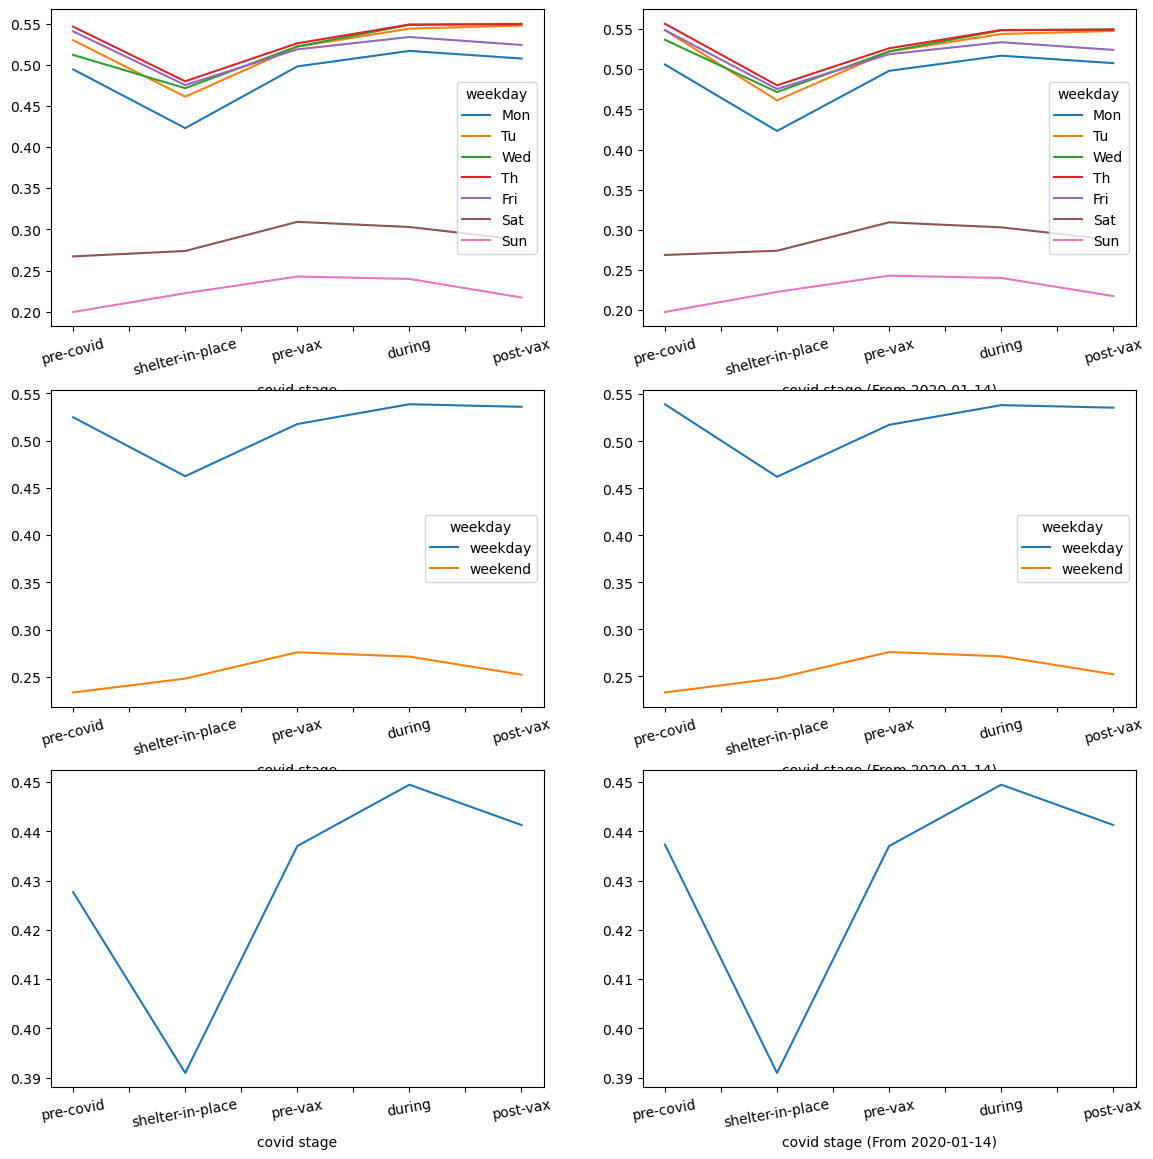

In [242]:
# Lockdown start from 3/16/20
# seq = ['pre-pandemic', 'lockdown', 'pre-vaccine', 'early-vaccine', 'post-vaccine', 'omicron', 'post-covid']
seq = ['pre-covid', 'shelter-in-place', 'pre-vax', 'during', 'post-vax']

df_1.rename(columns = dict(zip([i for i in range(7)], ['Mon', 'Tu', 'Wed', 'Th', 'Fri', 'Sat', 'Sun'])), inplace = True)
df_2.rename(columns = dict(zip([i for i in range(7)], ['Mon', 'Tu', 'Wed', 'Th', 'Fri', 'Sat', 'Sun'])), inplace = True)
df_1['weekday'] = df_1.loc[:, 'Mon':'Fri'].mean(axis = 1)
df_1['weekend'] = df_1.loc[:, 'Sat':'Sun'].mean(axis = 1)
df_2['weekday'] = df_2.loc[:, 'Mon':'Fri'].mean(axis = 1)
df_2['weekend'] = df_2.loc[:, 'Sat':'Sun'].mean(axis = 1)

fig, axs = plt.subplots(3, 2, figsize = (14, 14)) 
df_1.loc[seq, :'Sun'].plot(rot = 15, ax = axs[0, 0], xlabel = 'covid stage')
df_2.loc[seq, :'Sun'].plot(rot = 15, ax = axs[0, 1], xlabel = 'covid stage (From 2020-01-14)')
df_1[['weekday', 'weekend']].loc[seq].plot(rot = 15, ax = axs[1, 0], xlabel = 'covid stage')
df_2[['weekday', 'weekend']].loc[seq].plot(rot = 15, ax = axs[1, 1], xlabel = 'covid stage (From 2020-01-14)')
df_1.T.describe().loc['mean'][seq].plot(rot = 10, ax = axs[2, 0], xlabel = 'covid stage')
df_2.T.describe().loc['mean'][seq].plot(rot = 10, ax = axs[2, 1], xlabel = 'covid stage (From 2020-01-14)')

In [57]:
rec = pd.read_csv(csv_files[0], parse_dates = ['date'])
rec = rec[rec.weekday < 5]
rec['week'] = rec['date'].dt.isocalendar().week
rec['year'] = rec['date'].dt.isocalendar().year
freq_ = rec.groupby(['year', 'week'])['commute_filled'].mean().unstack()
count_ = 1 - freq_.isnull().astype(int)
freq_.fillna(0, inplace = True)

for f in csv_files[1:]:
    rec = pd.read_csv(f, parse_dates = ['date'])
    rec = rec[rec.weekday < 5]
    rec['week'] = rec['date'].dt.isocalendar().week
    rec['year'] = rec['date'].dt.isocalendar().year
    freq = rec.groupby(['year', 'week'])['commute_filled'].mean().unstack()
    count = 1 - freq.isnull().astype(int)
    freq.fillna(0, inplace = True)
    
    freq_ += freq
    count_ += count

In [31]:
from datetime import date
df = pd.DataFrame((freq_/count_).stack())
df.rename(columns = {0: 'freq'}, inplace = True)
df.reset_index(inplace = True)
df['date'] = df.apply(lambda x: date.fromisocalendar(int(x.year), int(x.week), 1), axis = 1)
df.set_index('date', inplace = True)

In [32]:
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

/tmp/ipykernel_140159/619818143.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_minor_formatter(ticker.FixedFormatter(df.week))


Text(2022-05-15, 0.575, 'post-vax')

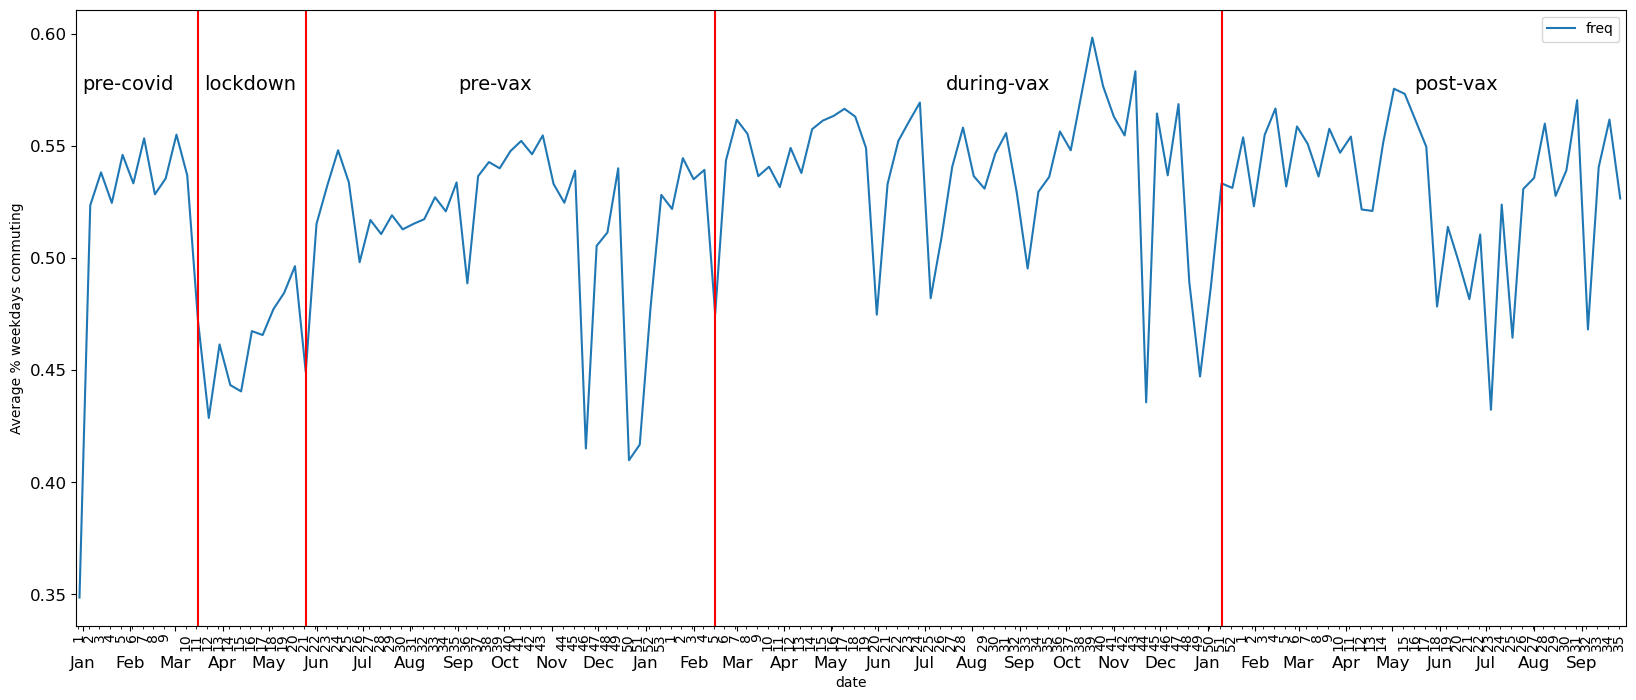

In [85]:
ax = df[['freq']].plot(figsize = (20, 8), ylabel = 'Average % weekdays commuting', fontsize = 12)
ax.set_xlim([date(2019, 12, 28), date(2022,9, 30)])
months = mdates.MonthLocator(interval = 1)
months_fmt = mdates.DateFormatter('%b')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)
days = mdates.DayLocator(interval = 7)
ax.xaxis.set_minor_locator(days)
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(df.week))
ax.tick_params(axis = 'x', which = 'major', pad = 18)
ax.tick_params(axis = 'x', which = 'minor', rotation = 90)
# for i in ['2020-03-16', '2020-05-25', '2020-11-23', '2020-12-21', 
#           '2021-01-04', '2021-11-22', '2021-12-20', '2022-01-03',
#           '2022-07-04', '2022-07-18']:
for i in ['2020-03-16', '2020-05-25', '2021-02-15', '2022-01-10']:
    ax.axvline(i, color = 'red')
plt.text('2020-01-01', 0.575, 'pre-covid', fontsize = 14)
plt.text('2020-03-20', 0.575, 'lockdown', fontsize = 14)
plt.text('2020-09-01', 0.575, 'pre-vax', fontsize = 14)
plt.text('2021-07-15', 0.575, 'during-vax', fontsize = 14)
plt.text('2022-05-15', 0.575, 'post-vax', fontsize = 14)

In [16]:
import re
df_ = pd.DataFrame()
for f in csv_files:
    df = pd.read_csv(f, parse_dates = ['date'], usecols = lambda x: 'Unnamed' not in x)
    df = df.loc[(df.date >= '2020-01-06')]
    demo_ = demo[demo.panelist_id == re.split(r'_|\.', f)[1]]
    df['dfrw'] = demo_['dfrw_cap_mean'].values[0]           
    df['income'] = demo_['hh_income_mid'].values[0]
    df['college'] = 1 if demo_['edu_level'].values[0] in ['University/College', 'Postgraduate Education'] else 0
    df_ = pd.concat([df_, df])

In [17]:
df_['logincome'] = np.log(df_['income'])
df_['dfrw_1000'] = df_['dfrw']/1000
df_.rename(columns = {'pre-covid': 'pre_covid', 'pre-vax': 'pre_vax', 'post-vax': 'post_vax', 'shelter-in-place': 'sip'}, inplace = True)
df_['during_post'] = df_['during'] + df_['post_vax']
df_['is_weekday'] = 1 - df_['is_weekend']

In [18]:
df_.describe()

,weekday,commute,commute_filled,missing,cases_avg_s,cases_avg_s_1wkbf,cases_avg_s_2wkbf,cases_avg_c,cases_avg_c_1wkbf,cases_avg_c_2wkbf,...,pre_covid,pre_vax,sip,dfrw,income,college,logincome,dfrw_1000,during_post,is_weekday
count,512680.000000,496151.000000,512680.000000,512680.000000,512680.000000,512680.000000,512680.000000,512680.000000,512680.000000,512680.000000,...,512680.000000,512680.000000,512680.000000,512680.000000,512680.000000,512680.000000,512680.000000,512680.000000,512680.000000,512680.000000
mean,2.995406,0.456490,0.451139,0.032240,3652.117521,3613.877561,3574.144022,284.939718,282.276971,279.536694,...,0.074596,0.289473,0.084942,16279.192529,59751.575057,0.521840,10.788319,16.279193,0.550989,0.715226
std,1.999671,0.498104,0.497607,0.176638,7739.758233,7681.783369,7619.276809,978.023861,975.759370,973.176571,...,0.262739,0.453518,0.278795,16544.471536,38982.404482,0.499523,0.682532,16.544472,0.497394,0.451307
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,269.004482,7500.000000,0.000000,8.922658,0.269004,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,480.430000,459.252500,437.252500,14.140000,13.290000,12.570000,...,0.000000,0.000000,0.000000,5631.900166,37500.000000,0.000000,10.532096,5.631900,0.000000,0.000000
50%,3.000000,0.000000,0.000000,0.000000,1403.570000,1379.000000,1354.710000,70.570000,68.860000,67.290000,...,0.000000,0.000000,0.000000,12027.464168,37500.000000,1.000000,10.532096,12.027464,1.000000,1.000000
75%,5.000000,1.000000,1.000000,0.000000,3706.250000,3677.140000,3622.290000,224.430000,222.000000,218.710000,...,0.000000,1.000000,0.000000,20926.771529,65000.000000,1.000000,11.082143,20.926772,1.000000,1.000000
max,6.000000,1.000000,1.000000,1.000000,119536.140000,119536.140000,119536.140000,41682.000000,41682.000000,41682.000000,...,1.000000,1.000000,1.000000,155562.174673,250000.000000,1.000000,12.429216,155.562175,1.000000,1.000000


In [10]:
import statsmodels.api as sm
from statsmodels.formula.api import logit

formula = ('commute_filled ~ dfrw_1000 + logincome + college + sip + pre_vax + during_post + is_weekend + sip * is_weekend + pre_vax * is_weekend + during_post * is_weekend')
model = logit(formula = formula, data = df_).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.654478
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         commute_filled   No. Observations:               509096
Model:                          Logit   Df Residuals:                   509085
Method:                           MLE   Df Model:                           10
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                 0.04924
Time:                        14:32:59   Log-Likelihood:            -3.3319e+05
converged:                       True   LL-Null:                   -3.5045e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1.8816      0.049     38.328      0.000       1.785       1.978
dfrw_1000                 -0.0065      0.000    -35.392      0.000      -0.007      -0.006
logincome                 -0.1413      0.004    -31.516      0.000      -0.150      -0.133
college                   -0.1738      0.006    -28.628      0.000      -0.186      -0.162
sip                       -0.3134      0.017    -18.303      0.000      -0.347      -0.280
pre_vax                   -0.0902      0.014     -6.336      0.000      -0.118      -0.062
during_post               -0.0070      0.014     -0.512      0.609      -0.034       0.020
is_weekend                -1.3628      0.027    -50.426      0.000      -1.416      -1.310
sip:is_weekend             0.3977      0.036     10.907      0.000       0.326       0.469
pre_vax:is_weekend         0.3195      0.030     10.726      0.000       0.261       0.378
during_post:is_weekend     0.1822      0.029      6.387      0.000       0.126       0.238
==========================================================================================
"""

In [107]:
formula = ('commute_filled ~ dfrw_1000 + logincome + college + sip : is_weekday + pre_vax : is_weekday + during_post : is_weekday + pre_covid : is_weekend + sip : is_weekend + pre_vax : is_weekend + during_post : is_weekend')
model = logit(formula = formula, data = df_).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.654478
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         commute_filled   No. Observations:               509096
Model:                          Logit   Df Residuals:                   509085
Method:                           MLE   Df Model:                           10
Date:                Sat, 09 Dec 2023   Pseudo R-squ.:                 0.04924
Time:                        00:05:42   Log-Likelihood:            -3.3319e+05
converged:                       True   LL-Null:                   -3.5045e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1.8816      0.049     38.328      0.000       1.785       1.978
dfrw_1000                 -0.0065      0.000    -35.392      0.000      -0.007      -0.006
logincome                 -0.1413      0.004    -31.516      0.000      -0.150      -0.133
college                   -0.1738      0.006    -28.628      0.000      -0.186      -0.162
sip:is_weekday            -0.3134      0.017    -18.303      0.000      -0.347      -0.280
pre_vax:is_weekday        -0.0902      0.014     -6.336      0.000      -0.118      -0.062
during_post:is_weekday    -0.0070      0.014     -0.512      0.609      -0.034       0.020
pre_covid:is_weekend      -1.3628      0.027    -50.426      0.000      -1.416      -1.310
sip:is_weekend            -1.2784      0.025    -50.726      0.000      -1.328      -1.229
pre_vax:is_weekend        -1.1334      0.017    -67.341      0.000      -1.166      -1.100
during_post:is_weekend    -1.1875      0.015    -78.620      0.000      -1.217      -1.158
==========================================================================================
"""

In [12]:
formula = ('commute_filled ~ dfrw_1000 + logincome + college + is_holiday_extra + sip : is_weekday + pre_vax : is_weekday + during_post : is_weekday + pre_covid : is_weekend + sip : is_weekend + pre_vax : is_weekend + during_post : is_weekend')
model = logit(formula = formula, data = df_).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.652880
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         commute_filled   No. Observations:               509096
Model:                          Logit   Df Residuals:                   509084
Method:                           MLE   Df Model:                           11
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                 0.05156
Time:                        14:36:16   Log-Likelihood:            -3.3238e+05
converged:                       True   LL-Null:                   -3.5045e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1.9135      0.049     38.905      0.000       1.817       2.010
dfrw_1000                 -0.0066      0.000    -35.478      0.000      -0.007      -0.006
logincome                 -0.1419      0.004    -31.577      0.000      -0.151      -0.133
college                   -0.1744      0.006    -28.666      0.000      -0.186      -0.162
is_holiday_extra          -0.5859      0.015    -39.829      0.000      -0.615      -0.557
sip:is_weekday            -0.3289      0.017    -19.178      0.000      -0.362      -0.295
pre_vax:is_weekday        -0.0752      0.014     -5.270      0.000      -0.103      -0.047
during_post:is_weekday     0.0011      0.014      0.081      0.935      -0.026       0.028
pre_covid:is_weekend      -1.3885      0.027    -51.343      0.000      -1.442      -1.335
sip:is_weekend            -1.3042      0.025    -51.706      0.000      -1.354      -1.255
pre_vax:is_weekend        -1.1592      0.017    -68.750      0.000      -1.192      -1.126
during_post:is_weekend    -1.2132      0.015    -80.150      0.000      -1.243      -1.184
==========================================================================================
"""

In [19]:
import statsmodels.api as sm
from statsmodels.formula.api import logit

formula = ('commute_filled ~ dfrw_1000 + logincome + college + is_holiday_extra + sip + pre_vax + during_post + is_weekend')
# formula = ('commute_filled ~ dfrw_1000 + logincome + college + is_holiday_extra + sip:is_weekday + pre_vax:is_weekday + during_post:is_weekday + is_weekend')
model = logit(formula = formula, data = df_).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.653064
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         commute_filled   No. Observations:               512680
Model:                          Logit   Df Residuals:                   512671
Method:                           MLE   Df Model:                            8
Date:                Sun, 17 Dec 2023   Pseudo R-squ.:                 0.05128
Time:                        19:21:02   Log-Likelihood:            -3.3481e+05
converged:                       True   LL-Null:                   -3.5291e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.8494      0.049     38.124      0.000       1.754       1.944
dfrw_1000           -0.0066      0.000    -35.642      0.000      -0.007      -0.006
logincome           -0.1411      0.004    -31.521      0.000      -0.150      -0.132
college             -0.1748      0.006    -28.839      0.000      -0.187      -0.163
is_holiday_extra    -0.5850      0.015    -39.797      0.000      -0.614      -0.556
sip                 -0.2282      0.015    -15.564      0.000      -0.257      -0.199
pre_vax              0.0018      0.012      0.151      0.880      -0.022       0.025
during_post          0.0456      0.011      4.025      0.000       0.023       0.068
is_weekend          -1.1687      0.007   -169.877      0.000      -1.182      -1.155
====================================================================================
"""

In [34]:
def commute_freq(d):
    fre_ = pd.Series(dict(zip([i for i in range(7)], [0] * 7)))
    count_ = pd.Series(dict(zip([i for i in range(7)], [0] * 7)))
    for i in csv_files:
        rec = pd.read_csv(i, usecols = lambda x: 'Unnamed' not in x, parse_dates = ['date'])
        rec = rec[(rec.date >= d) & (rec.date <= '2020-03-05')]
        fre = rec.groupby(['weekday'])['commute_filled'].sum()
        count = rec.groupby(['weekday']).size()
        if 4 not in fre.index:
            fre.loc[4] = 0
            count.loc[4] = 0
        fre_ += fre
        count_ += count
    return fre_/count_

In [42]:
df = pd.DataFrame(columns = [i for i in range(7)])
for d in pd.date_range(start = '12/23/2019', end = '1/13/20', freq = 'W-MON'):
    df.loc[d] = commute_freq(d)

In [44]:
df

,0,1,2,3,4,5,6
2019-12-23,0.492454,0.529003,0.511493,0.545370,0.537156,0.264026,0.202300
2019-12-30,0.492454,0.529003,0.511493,0.545573,0.537490,0.264354,0.202803
2020-01-06,0.507822,0.546201,0.536790,0.556191,0.545875,0.266190,0.201058
2020-01-13,0.507699,0.550103,0.539272,0.556849,0.546814,0.264837,0.200104
